In [1]:
import pandas as pd
import os
from caveclient import CAVEclient
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
client = CAVEclient()

if not os.path.isfile(os.path.expanduser("~/.cloudvolume/secrets/cave-secret.json")):
    client.auth.get_new_token(open=True)

datastack_name = 'fanc_production_mar2021'

client = CAVEclient(datastack_name)

In [3]:
def filt_syn_df(syn_df, syn_thresh):
    
    indices_to_include = []

    # Find unique presynaptic neurons
    unique_pre_ids = syn_df.pre_pt_root_id.unique().tolist()

    # Loop through presynaptic neurons
    for i in unique_pre_ids:       
        pre_df = syn_df[syn_df.pre_pt_root_id == i]
        # Find unique postsynaptic neurons targeted by i-th presynaptic neuron
        unique_post_ids = pre_df.post_pt_root_id.unique().tolist() 
        # Loop through postsynaptic neurons
        for j in unique_post_ids:    
            # Is number of synapses onto j-th postsynaptic neuron larger than or equal to syn_thresh? 
            if sum(pre_df.post_pt_root_id == j) >= syn_thresh: 
                # Get indices (rows)
                indices = pre_df.index.values[pre_df.post_pt_root_id == j]       
                # Loop through indices 
                for k in indices:
                    # Append each index separately to avoid lists within list
                    indices_to_include.append(k)

    # Sort indices in ascending order
    indices_to_include.sort()
    
    # Create new syn_df with only connections above syn_thresh
    syn_df_filt = syn_df.loc[indices_to_include]
    
    return syn_df_filt

In [90]:
# get neurons that are downstream of t1l clubs 
# and are classified as 10B/8B/0A/9A... 

feco_df_all = client.materialize.query_table('feco_axons_v0')
t1l_club_df = feco_df_all[(feco_df_all.cell_type.str.contains('club')) & (feco_df_all.classification_system == 'T1L')]

upstream = False
syn_thresh = 4
inputs = t1l_club_df.pt_root_id.tolist()

if upstream == True:
    syn_df = client.materialize.synapse_query(post_ids = inputs)
else:
    syn_df = client.materialize.synapse_query(pre_ids = inputs)

synapse_df = filt_syn_df(syn_df, syn_thresh)
syn_per_conn= synapse_df.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=["number_of_synapses"]).sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)


downstream_feco_df_all = client.materialize.query_table('downstream_feco_axons_v1')
cell_type = [] 
classification = [] 

for idx in syn_per_conn.post_pt_root_id.tolist(): 
    if idx in downstream_feco_df_all.pt_root_id.tolist(): 
        cell_type.append(downstream_feco_df_all[downstream_feco_df_all.pt_root_id == idx].cell_type.tolist()[0]) 
        classification.append(downstream_feco_df_all[downstream_feco_df_all.pt_root_id == idx].classification_system.tolist()[0]) 

    else: 

        cell_type.append('uk')
        classification.append('uk')

syn_per_conn['cell_type'] = cell_type
syn_per_conn['classification'] = classification

In [ ]:
t1l_10b = syn_per_conn[syn_per_conn.cell_type == '10B'].post_pt_root_id.unique().tolist()
t1l_8b = syn_per_conn[syn_per_conn.cell_type == '8B'].post_pt_root_id.unique().tolist()
t1l_0a = syn_per_conn[syn_per_conn.cell_type == '0A/0B'].post_pt_root_id.unique().tolist()
t1l_9a = syn_per_conn[(syn_per_conn.cell_type == '9A') & (syn_per_conn.classification.str.contains('local'))].post_pt_root_id.unique().tolist()

In [154]:
#iteratively create synapse dataframe from cosine_inputs 
# grab post_pt_position (synapse position) from each dataframe for each neuron 

def sort_synapses(inputs, syn_thresh, upstream_option): 
#     inputs = t1l_10b
    x_synapses = [] 
    y_synapses = [] 
    z_synapses = [] 
    neuron_idx = [] 
    counter = 0

    for idx in inputs:
        upstream = upstream_option  
#         syn_thresh = 4

        if upstream == True:
            syn_df = client.materialize.synapse_query(post_ids = idx) # create synapse df for each segid 
        else:
            syn_df = client.materialize.synapse_query(pre_ids = idx)

        synapse_df = filt_syn_df(syn_df, syn_thresh)
        synapse_df = synapse_df.reset_index()
        neuron_idx.extend(np.ones(len(synapse_df)) * counter) # create neuron index to reference later 
        counter = counter + 1 

        for synapse in range(0, len(synapse_df)): 
            if upstream == True: 
                x_synapses.append(synapse_df.pre_pt_position[synapse][0]) # fill x,y,z synapse positions 
                y_synapses.append(synapse_df.pre_pt_position[synapse][1]) 
                z_synapses.append(synapse_df.pre_pt_position[synapse][2]) 

            else: 
                x_synapses.append(synapse_df.post_pt_position[synapse][0]) 
                y_synapses.append(synapse_df.post_pt_position[synapse][1]) 
                z_synapses.append(synapse_df.post_pt_position[synapse][2]) 


    # Create dataframe for plotting 
    synapse_hist = {'x_synapses': x_synapses,
                    'y_synapses': y_synapses, 
                    'z_synapses': z_synapses, 
                    'neuron' : neuron_idx}

    # Create DataFrame
    synapse_hist_df = pd.DataFrame(synapse_hist) #categorize synapse position into t1/t2/t3 and l/r 

    # t1_y = <118663 
    # t2_y = 118664 : 161304 
    # t3_y = 161304

    t1_y_thresh = 118663 # less than

    t2_y_thresh = 118664 # greater than

    t3_y_thresh = 155000 # greater than

    l_thresh = 36000 # greater than 


    synapse_input = synapse_hist_df 
    synapse_sum = np.zeros((3, 2))


    for idx in range(0, len(synapse_input)): 
        if synapse_input.x_synapses[idx] < l_thresh: 
            if synapse_input.y_synapses[idx] <= t1_y_thresh:

                synapse_sum[0, 0] = synapse_sum[0, 0] + 1 #t1l 

            elif synapse_input.y_synapses[idx] >= t2_y_thresh and synapse_input.y_synapses[idx] <= t3_y_thresh:
                synapse_sum[1,0] = synapse_sum[1, 0] + 1 #t2l 

            else: 
                pass

        if synapse_input.x_synapses[idx] >= l_thresh:
            if synapse_input.y_synapses[idx] <= t1_y_thresh: 
                synapse_sum[0,1] = synapse_sum[0,1] + 1 #t1r

            elif synapse_input.y_synapses[idx] >= t2_y_thresh and synapse_input.y_synapses[idx] <= t3_y_thresh:
                synapse_sum[1,1] = synapse_sum[1,1] + 1 #t2r

            else: 
                pass

        if synapse_input.y_synapses[idx] >= t3_y_thresh: 

            if synapse_input.x_synapses[idx] >= 44000: 
                synapse_sum[2,1] = synapse_sum[2,1] + 1 #t3r 

            else: 
                synapse_sum[2,0] = synapse_sum[2,0] + 1 #t3l 

    return synapse_sum 

In [159]:
synapse_sum_10b_pre = sort_synapses(t1l_10b, 3, True)  # False = postsynaptic
synapse_sum_8b_pre = sort_synapses(t1l_8b, 3, True)
synapse_sum_0a_pre = sort_synapses(t1l_0a, 3, True)
synapse_sum_9a_pre = sort_synapses(t1l_9a, 3, True)

synapse_sum_10b = sort_synapses(t1l_10b, 4, False)  # False = postsynaptic
synapse_sum_8b = sort_synapses(t1l_8b, 4, False)
synapse_sum_0a = sort_synapses(t1l_0a, 4, False)
synapse_sum_9a = sort_synapses(t1l_9a, 4, False)

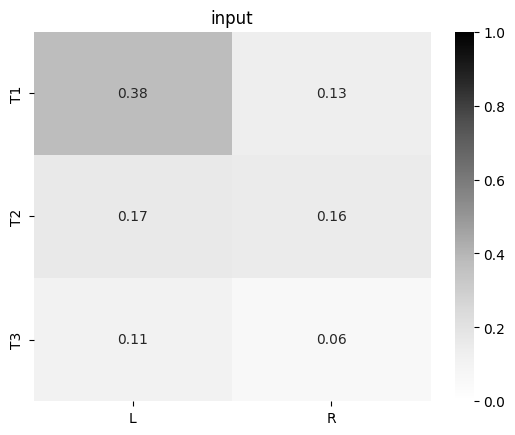

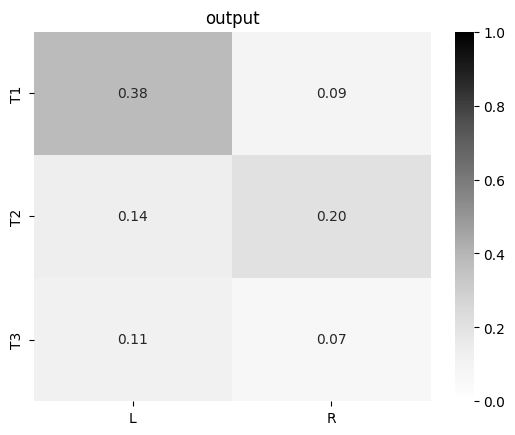

In [190]:
# cmap = sns.cubehelix_palette(n_colors = 20, start = 32, rot=0, dark=0, light=1) # red
# cmap = sns.color_palette('Blues', as_cmap=True)
vM = 1
vMi = 0
ax = sns.heatmap(synapse_sum_10b_pre / np.sum(synapse_sum_10b_pre), vmin = vMi, vmax = vM, cmap = 'Greys', cbar = True, annot = True, fmt=".2f")
ax.set_yticks([0.5,1.5,2.5])
ax.set_yticklabels(['T1','T2','T3'])
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['L', 'R'])
plt.title('input')
# plt.savefig('heatmap_save.pdf', dpi = 300)
plt.show()


vM = 1
vMi = 0
ax = sns.heatmap(synapse_sum_10b / np.sum(synapse_sum_10b), vmin = vMi, vmax = vM, cmap = 'Greys', cbar = True, annot = True, fmt=".2f")
ax.set_yticks([0.5,1.5,2.5])
ax.set_yticklabels(['T1','T2','T3'])
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['L', 'R'])
plt.title('output')
# plt.savefig('heatmap_save.pdf', dpi = 300)
plt.show()

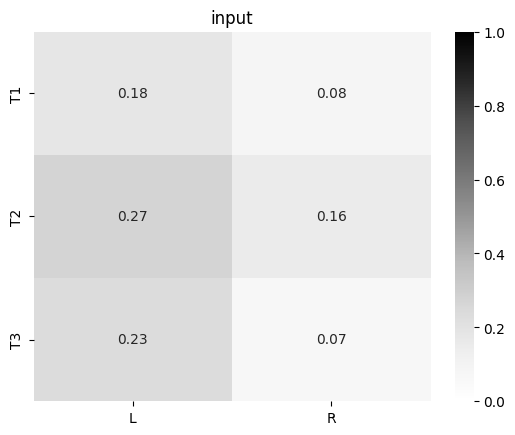

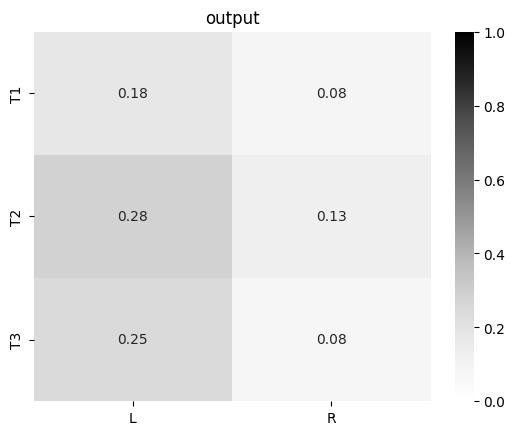

In [180]:
# cmap = sns.cubehelix_palette(n_colors = 20, start = 90, rot=0.2, dark=0, light=1)
vM = 1
vMi = 0
ax = sns.heatmap(synapse_sum_8b_pre / np.sum(synapse_sum_8b_pre), vmin = vMi, vmax = vM, cmap = 'Greys', cbar = True, annot = True, fmt=".2f")
ax.set_yticks([0.5,1.5,2.5])
ax.set_yticklabels(['T1','T2','T3'])
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['L', 'R'])
plt.title('input')
# plt.savefig('heatmap_save.pdf', dpi = 300)
plt.show()


vM = 1
vMi = 0
ax = sns.heatmap(synapse_sum_8b / np.sum(synapse_sum_8b), vmin = vMi, vmax = vM, cmap = 'Greys', cbar = True, annot = True, fmt=".2f")
ax.set_yticks([0.5,1.5,2.5])
ax.set_yticklabels(['T1','T2','T3'])
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['L', 'R'])
plt.title('output')
# plt.savefig('heatmap_save.pdf', dpi = 300)
plt.show()

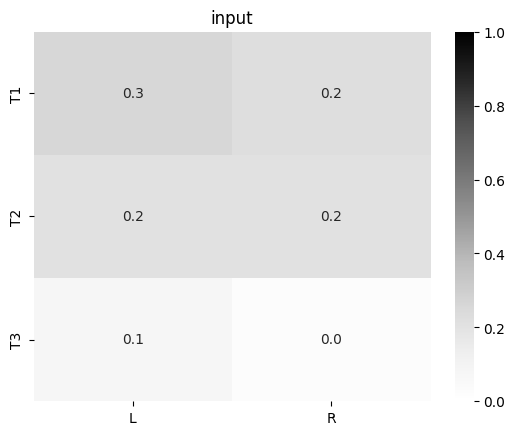

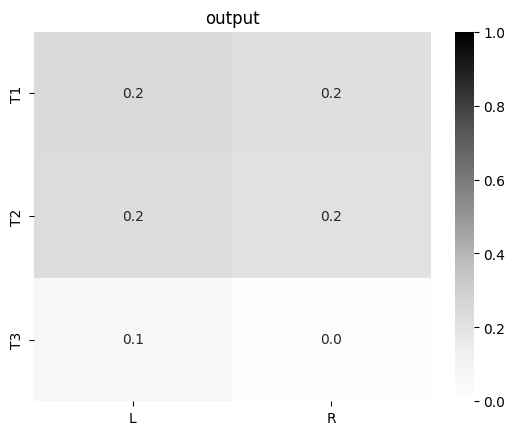

In [191]:
cmap = sns.cubehelix_palette(n_colors = 20, start = 90, rot=0.2, dark=0, light=1) # red

vM = 1
vMi = 0
ax = sns.heatmap(synapse_sum_0a_pre / np.sum(synapse_sum_0a_pre), vmin = vMi, vmax = vM, cmap = 'Greys', cbar = True, annot = True, fmt=".2f")
ax.set_yticks([0.5,1.5,2.5])
ax.set_yticklabels(['T1','T2','T3'])
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['L', 'R'])
# plt.savefig('heatmap_save.pdf', dpi = 300)
plt.title('input')
plt.show()


vM = 1
vMi = 0
ax = sns.heatmap(synapse_sum_0a / np.sum(synapse_sum_0a), vmin = vMi, vmax = vM, cmap = 'Greys', cbar = True, annot = True, fmt=".2f")
ax.set_yticks([0.5,1.5,2.5])
ax.set_yticklabels(['T1','T2','T3'])
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['L', 'R'])
plt.title('output')
# plt.savefig('heatmap_save.pdf', dpi = 300)
plt.show()

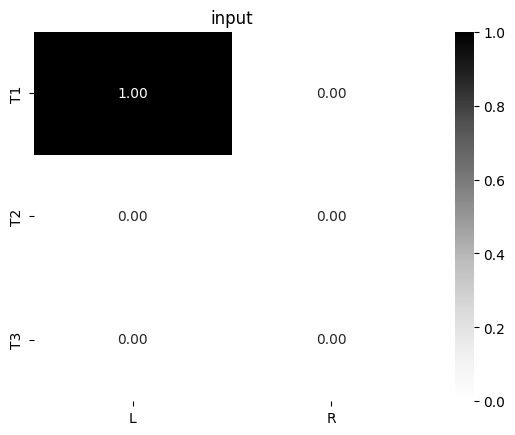

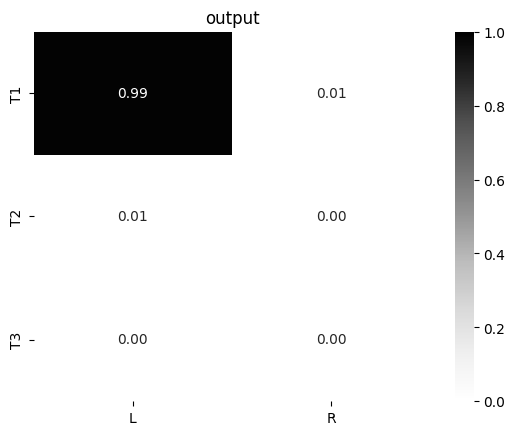

In [193]:
# cmap = sns.cubehelix_palette(n_colors = 20, start = 90, rot=0.2, dark=0, light=1) # red

vM = 1
vMi = 0
ax = sns.heatmap(synapse_sum_9a_pre / np.sum(synapse_sum_9a_pre), vmin = vMi, vmax = vM, cmap = 'Greys', cbar = True, annot = True, fmt=".2f")
ax.set_yticks([0.5,1.5,2.5])
ax.set_yticklabels(['T1','T2','T3'])
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['L', 'R'])
plt.title('input')
# plt.savefig('heatmap_save.pdf', dpi = 300)
plt.show()


vM = 1
vMi = 0
ax = sns.heatmap(synapse_sum_9a / np.sum(synapse_sum_9a), vmin = vMi, vmax = vM, cmap = 'Greys', cbar = True, annot = True, fmt=".2f")
ax.set_yticks([0.5,1.5,2.5])
ax.set_yticklabels(['T1','T2','T3'])
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['L', 'R'])
plt.title('output')
# plt.savefig('heatmap_save.pdf', dpi = 300)
plt.show()